In [12]:
import utilities as ut
import pandas as pd
import numpy as np
import json
from scipy import stats
from functools import reduce
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette("colorblind")

# 1. SafeGraph data

## Read data and drop NAs

In [ ]:
NY_Oct_2019 = ut.read_raw_data('Oct2019_monthly', 'NY', 29)
# NY_Oct_2019.to_csv('NY_Oct_2019.csv', index = False)

In [3]:
NY_Oct_2019 = pd.read_csv('NY_Oct_2019.csv')

In [4]:
NY_Oct_2019.shape

(264826, 53)

In [5]:
print('number of obeservations in the New York State Data', len(NY_Oct_2019))
print("number of top_category (4-digit NAICS code)", len(NY_Oct_2019["top_category"].unique()))
print("number of sub_category (6-digit NAICS code)", len(NY_Oct_2019["sub_category"].unique()))

number of obeservations in the New York State Data 264826
number of top_category (4-digit NAICS code) 28
number of sub_category (6-digit NAICS code) 78


In [ ]:
# save top_categories, 4-digit NAICS, and number of POIs in each category for reporting
cat4n = NY_Oct_2019[["top_category", 'naics_code']]
cat4n = cat4n.assign(naic_4digits = cat4n['naics_code'].astype("int").astype('str').str.slice(0,4))
cat4n = cat4n[["top_category", 'naic_4digits']].groupby(["top_category", 'naic_4digits']).size().to_frame()
cat4n = cat4n.reset_index()
cat4n.columns.values[2] = "n_POIs"
cat4n = cat4n.sort_values("n_POIs", ascending = False).reset_index(drop = True)

# cat4n.to_excel("Appendix/TableA1_four_digit_industries.xlsx")

In [7]:
# delete the unlabelled data
NY_brands = NY_Oct_2019.dropna(subset = ['brands'])
print('number of records that are labelled with brands', len(NY_brands))
print('proportion of labelled brands', len(NY_brands) / len(NY_Oct_2019))
print('number of brands', len(pd.unique(NY_brands['brands'])))

number of records that are labelled with brands 35588
proportion of labelled brands 0.13438257572896922
number of brands 1421


In [8]:
# worth noting, some categories does not have labelled brands
set(NY_Oct_2019['top_category'].unique()) - set(NY_brands['top_category'].unique())

{'Gambling Industries',
 'Museums, Historical Sites, and Similar Institutions',
 'Performing Arts Companies',
 'Special Food Services'}

In [9]:
# showing that places with NaN for 'related_same_day_brand' also has NaN for 'raw_visit_counts', 
# and for 'visitor_home_cbgs', 'related_same_day_brand'
# so not much can be done to inspect the missing data for 'related_same_day_brand',
# just delete them for now
print(sum(NY_brands['related_same_month_brand'].isna() & NY_brands['raw_visit_counts'].notna()))
print(sum(NY_brands['related_same_month_brand'].isna() & NY_brands['visitor_home_cbgs'].notna()))
print(sum(NY_brands['related_same_month_brand'].isna() & NY_brands['related_same_day_brand'].notna()))

0
0
0


In [ ]:
# drop NA and save
NY_brands = NY_brands.dropna(subset = ['related_same_month_brand'])
# NY_brands.to_csv('NY_brands.csv', index = False)

In [11]:
print("number of brands:", len(pd.unique(NY_brands['brands'])))
print("number of rows:", len(NY_brands))

number of brands: 1175
number of rows: 24188


## Unpack 'visitor_home_cbgs' (a json column)


In [ ]:
NY_brands = pd.read_csv('NY_brands.csv')

In [12]:
sum(NY_brands['visitor_home_cbgs'] == '{}')

652

In [13]:
sum(NY_brands['visitor_home_cbgs'] != '{}')

23536

In [4]:
cbg_unpack = ut.unpack_home_cbgs(NY_brands)

In [5]:
# remove cbgs in Canada
cbg_unpack = cbg_unpack[~cbg_unpack['visitor_home_cbgs'].str.startswith("CA:")]

In [6]:
cbg_unpack

,placekey,brands,visitor_home_cbgs,cbg_visitor_count
0,zzw-23k@627-s8r-dgk,CVS,120330011031,4
1,zzw-23k@627-s8r-dgk,CVS,421010030012,4
2,zzw-23k@627-s8r-dgk,CVS,360810717013,4
3,zzw-23k@627-s8r-dgk,CVS,360810291002,4
4,zzw-23k@627-s8r-dgk,CVS,360470257003,4
...,...,...,...,...
1204751,22b-222@627-tn2-f4v,Gulf Oil,360811175003,4
1204752,22b-222@627-tn2-f4v,Gulf Oil,360594169001,4
1204753,22b-222@627-tn2-f4v,Gulf Oil,360595185023,4
1204754,22b-222@627-tn2-f4v,Gulf Oil,361031580012,4


In [8]:
len(cbg_unpack['visitor_home_cbgs'].unique())

54307

In [9]:
# cbg_unpack.to_csv('cbg_unpack.csv', index = False)

## selecting CBGs and brands based on number of visitors

In [ ]:
# get the matrix of cbg * brand
cbg_brand = cbg_unpack.drop('placekey', axis = 1) # drop placekey as it is not useful here
cbg_brand = cbg_brand.groupby(['visitor_home_cbgs', 'brands']).sum()
cbg_brand = cbg_brand.unstack()
cbg_brand = cbg_brand.fillna(0) # replace NaN as 0
cbg_brand.columns = cbg_brand.columns.droplevel(0)
cbg_brand.index.name = 'cbg'
## get cbgs that have income data available
cbg_brand = cbg_brand[cbg_brand.index.isin(cbg_income.index)]

In [ ]:
cbg_brand

brands,& Other Stories,&pizza,1-800-Flowers,10 Spot/MadRag,110 Grill,16 Handles,24 Hour Fitness,2nd Wind Exercise Equipment,5 Napkin Burger,5 Star Nutrition,...,iFresh Market,iLoveKickboxing,iPic Entertainment,itsu,junzi,lululemon athletica,maurices,rue21,sweetgreen,vineyard vines
cbg,,,,,,,,,,,,,,,,,,,,,
010010201002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
010010205001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
010010206001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
010010208024,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
010030103003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
721390602123,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
721390603022,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
721455602011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# cbg_brand.to_csv('cbg_brand.csv')

In [ ]:
rowsum = cbg_brand.sum(axis=1)
colsum = cbg_brand.sum(axis=0)
selected_cbg_brand = cbg_brand.loc[rowsum >= 100, colsum >= 100]

In [ ]:
selected_cbg_brand

brands,& Other Stories,&pizza,1-800-Flowers,10 Spot/MadRag,110 Grill,16 Handles,24 Hour Fitness,2nd Wind Exercise Equipment,5 Napkin Burger,5.11 Tactical,...,iFly Indoor Skydiving,iFresh Market,iLoveKickboxing,itsu,junzi,lululemon athletica,maurices,rue21,sweetgreen,vineyard vines
cbg,,,,,,,,,,,,,,,,,,,,,
060377019021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
090010101011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
090010101012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
090010101013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0
090010101014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421179504001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
421179505003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
421179506002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
sum(selected_cbg_brand.isna().sum())

0

In [ ]:
selected_brands = pd.DataFrame({'brands': selected_cbg_brand.columns.values})

# selected_cbg_brand.to_csv("selected_cbg_brand.csv")
# selected_brands.to_csv('selected_brands.csv', index = False)

## get brand categories

In [ ]:
brand_cat = ut.get_brand_cat(NY_brands)
# brand_cat.to_csv('brand_cat.csv', index = False)

## get covisit edgelist and matrix

In [3]:
NY_brands = pd.read_csv('NY_brands.csv')

In [3]:
# some cases 'related_same_month_brand' is empty dictionary
sum(NY_brands['related_same_month_brand'] == '{}')

28

In [4]:
sum(NY_brands['related_same_month_brand'] != '{}')

24160

In [5]:
covisit_edgelist = ut.get_covisit_edgelist(NY_brands, 'related_same_month_brand')

In [6]:
covisit_edgelist

,brands,related_same_month_brand,weight
0,& Other Stories,BP,8.707358
1,& Other Stories,Baskin Robbins,2.515050
2,& Other Stories,Bloomingdale's,1.836120
3,& Other Stories,Burger King,14.270903
4,& Other Stories,CVS,12.640468
...,...,...,...
60789,vineyard vines,Trader Joe's,0.129199
60790,vineyard vines,Walgreens,15.018088
60791,vineyard vines,Walmart,12.505168
60792,vineyard vines,Wendy's,6.089147


In [8]:
covisit_matrix = ut.get_covisit_matrix(covisit_edgelist, 'related_same_month_brand')

In [9]:
covisit_matrix

related_same_month_brand,& Other Stories,&pizza,1-800-Flowers,10 Spot/MadRag,16 Handles,24 Hour Fitness,2nd Wind Exercise Equipment,5 Napkin Burger,7 For All Mankind,7-Eleven,...,barre3,gorjana,honeygrow,iFly Indoor Skydiving,iLoveKickboxing,itsu,junzi,lululemon athletica,maurices,sweetgreen
brands,,,,,,,,,,,,,,,,,,,,,
& Other Stories,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.032642
&pizza,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.084485
1-800-Flowers,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.215167,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
10 Spot/MadRag,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
110 Grill,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
lululemon athletica,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142412,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.003836
maurices,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.112820,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000
rue21,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.089270,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [12]:
covisit_edgelist.to_csv('covisit_edgelist.csv', index = False)
covisit_matrix.to_csv('covisit_matrix.csv', index = False)

### noting outliers

'Spaghetti Warehouse Restaurant' have empty 'related_same_day_brand'.

In [13]:
set(pd.unique(NY_brands['brands'])) - set(pd.unique(covisit_edgelist['brands']))

{'Spaghetti Warehouse Restaurant'}

In [14]:
NY_brands[NY_brands['brands'] == 'Spaghetti Warehouse Restaurant']['related_same_day_brand']

20078    {}
Name: related_same_day_brand, dtype: object

# 2. census data

## median household income of cbgs

- B19013e1: Median Household Income In The Past 12 Months (In 2019 Inflation-Adjusted Dollars)

In [2]:
cbg_income = pd.read_csv('../SafeGraph_data/safegraph_open_census_data_2019/data/cbg_b19.csv', 
                         usecols = ['census_block_group','B19013e1'], dtype = {'census_block_group': str})
cbg_income = cbg_income.rename(columns={'census_block_group': 'cbg', 'B19013e1': 'income'})

In [15]:
# cbg_income.to_csv('cbg_income.csv', index = False)

## other demographic variables

### income variability 

- B19013m1: margin of error of median income
- magin of error = 1.645 SE https://www.census.gov/data/academy/webinars/2020/calculating-margins-of-error-acs.html

In [6]:
cbg_incomeMOE = pd.read_csv('../SafeGraph_data/safegraph_open_census_data_2019/data/cbg_b19.csv', 
                         usecols = ['census_block_group', 'B19013m1'], dtype = {'census_block_group': str})
cbg_incomeMOE = cbg_incomeMOE.rename(columns={'census_block_group': 'cbg', 'B19013m1': 'income_moe'})

### education: Educational Attainment For The Population 25 Years And Over
- B15003e1: Total population
- B15003e5: 1st grade
- B15003e6: 2nd grade
- B15003e7: 3rd grade
- B15003e8: 4th grade
- B15003e9: 5th grade
- B15003e10: 6th grade
- B15003e11: 7th grade
- B15003e12: 8th grade
- B15003e13: 9th grade
- B15003e14: 10th grade
- B15003e15: 11th grade
- B15003e16: 12th grade no diploma
- B15003e17: Regular high school diploma
- B15003e18: GED or alternative credential
- B15003e19: Some college less than 1 year
- B15003e20: Some college 1 or more years no degree
- B15003e21: Associate's degree
- B15003e22: Bachelor's degree
- B15003e23: Master's degree
- B15003e24: Professional school degree
- B15003e25: Doctorate degree

In [7]:
edu_cols = [f'B15003e{i}' for i in range(5, 26)]
cbg_edu = pd.read_csv('../SafeGraph_data/safegraph_open_census_data_2019/data/cbg_b15.csv', 
                         usecols = ['census_block_group','B15003e1'] + edu_cols, dtype = {'census_block_group': str})
cbg_edu["bachelor_or_higher"] = cbg_edu[['B15003e22', 'B15003e23','B15003e24','B15003e25']].sum(axis = 1) / cbg_edu['B15003e1']

# get weighted year of education with different weights for different levels of education
weights = np.append(np.arange(1, 13), [12, 12, 13, 14, 14, 16, 18, 19, 21])
cbg_edu['years_edu_weighted'] = np.sum(cbg_edu[edu_cols] * weights, axis=1) / cbg_edu['B15003e1']
cbg_edu = cbg_edu.rename(columns={'census_block_group': 'cbg'})
cbg_edu = cbg_edu[['cbg', 'bachelor_or_higher', 'years_edu_weighted']].dropna()

In [8]:
stats.pearsonr(cbg_edu['bachelor_or_higher'], cbg_edu['years_edu_weighted'])

(0.8878647232606229, 0.0)

In [9]:
# cbg_edu.to_csv('cbg_edu.csv', index = False)

### Age and sex
- 'B01001e1': Total population
- 'B01001e2': Male
- 'B01001e26': Female
- 'B01002e1': median age

In [10]:
cbg_age_sex = pd.read_csv('../SafeGraph_data/safegraph_open_census_data_2019/data/cbg_b01.csv',
                          usecols = ['census_block_group', 'B01001e1', 'B01001e2', 'B01001e26', 'B01002e1'],
                          dtype = {'census_block_group': str})

In [11]:
cbg_age_sex["male_proportion"] = cbg_age_sex['B01001e2'] / cbg_age_sex['B01001e1']
cbg_age_sex = cbg_age_sex.rename(columns={'census_block_group': 'cbg', 'B01002e1': 'median_age'})
cbg_age_sex = cbg_age_sex[['cbg', 'median_age', 'male_proportion']]

### Race
- 'B02001e1': total population
- 'B02001e2': white alone

In [12]:
cbg_race = pd.read_csv('../SafeGraph_data/safegraph_open_census_data_2019/data/cbg_b02.csv',
                          usecols = ['census_block_group', 'B02001e1', 'B02001e2'], 
                          dtype = {'census_block_group': str})

In [13]:
cbg_race['white_proportion'] = cbg_race['B02001e2'] / cbg_race['B02001e1']
cbg_race = cbg_race.rename(columns={'census_block_group': 'cbg'})
cbg_race = cbg_race[['cbg', 'white_proportion']]


## combine all

In [15]:
cbg_stats = reduce(lambda left,right: pd.merge(left, right, on = 'cbg', how = 'outer'),
                  [cbg_income, cbg_incomeMOE, cbg_edu, cbg_age_sex, cbg_race])

In [16]:
cbg_stats

,cbg,income,income_moe,bachelor_or_higher,years_edu_weighted,median_age,male_proportion,white_proportion
0,010010201001,35703.0,19018.0,0.178431,12.958824,43.3,0.401370,0.839726
1,010010201002,79000.0,12191.0,0.329643,13.755228,38.2,0.486144,0.848773
2,010010202001,26500.0,20685.0,0.095764,12.607735,38.7,0.470659,0.330539
3,010010202002,51042.0,4251.0,0.218605,12.977907,42.9,0.591637,0.429715
4,010010203001,59048.0,8926.0,0.196517,13.050249,37.3,0.512978,0.672675
...,...,...,...,...,...,...,...,...
220328,560459511001,53398.0,20196.0,0.215190,13.265823,45.3,0.506207,0.929655
220329,560459511002,51985.0,17010.0,0.207962,13.580645,50.5,0.605206,0.976681
220330,560459513001,44760.0,22878.0,0.127002,13.192220,35.5,0.541857,0.985540
220331,560459513002,59300.0,14716.0,0.189904,13.181490,44.5,0.475086,0.984536


In [17]:
cbg_stats.isna().sum()

cbg                      0
income                8299
income_moe            9131
bachelor_or_higher    1178
years_edu_weighted    1178
median_age            1190
male_proportion       1117
white_proportion      1117
dtype: int64

In [18]:
# cbg_stats.to_csv('cbg_stats.csv', index = False)

In [ ]:
selected_cbg_stats = cbg_stats.loc[selected_cbg_brand.index.values]
# selected_cbg_stats.to_csv('selected_cbg_stats.csv')

# 3. robustness check of selected vs other cbgs

In [9]:
cbg_stats = pd.read_csv('cbg_stats.csv', index_col = 'cbg')
cbg_brand = pd.read_csv('cbg_brand.csv', index_col = 'cbg')
selected_cbg_brand = pd.read_csv('selected_cbg_brand.csv', index_col = 'cbg')

In [10]:
sampled_cbg = list(set(cbg_brand.index.values) & set(cbg_stats.index.values))
sample_cbg_stats = cbg_stats.loc[sampled_cbg]
sample_cbg_stats['select_cbg'] = np.where(sample_cbg_stats.index.isin(selected_cbg_brand.index.values), 1, 0)
select_cbg_stats = sample_cbg_stats[sample_cbg_stats['select_cbg'] == 1]
other_cbg_stats = sample_cbg_stats[sample_cbg_stats['select_cbg'] == 0]

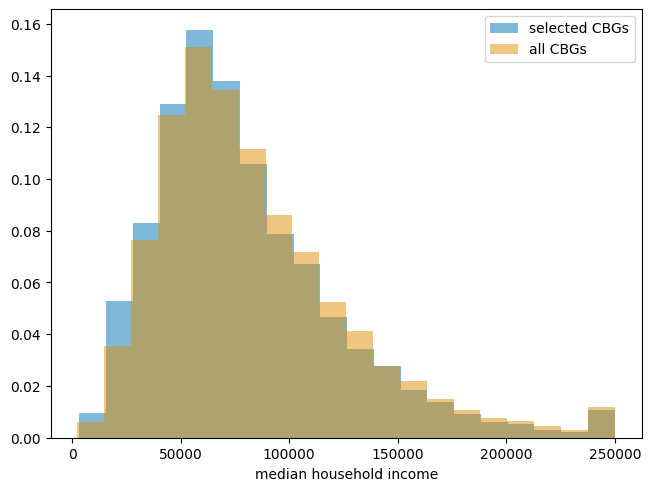

In [13]:
plt.figure(constrained_layout=True)
plt.hist(select_cbg_stats['income'], alpha=0.5, label='selected CBGs', bins= 20, weights = np.ones(len(select_cbg_stats)) / len(select_cbg_stats))
plt.hist(sample_cbg_stats['income'], alpha=0.5, label='all CBGs', bins=20, weights = np.ones(len(sample_cbg_stats)) / len(sample_cbg_stats))
plt.xlabel('median household income')
plt.legend()
plt.show()
# plt.savefig('Appendix/FigureA1.png', dpi = 300)